In [1]:
import os
os.environ [ "KMP_DUPLICATE_LIB_OK" ]= "TRUE"

%load_ext autoreload
%autoreload 2
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @Time    : 2022/6/9 15:46
# @Author  : Wang Yujia
# @File    : basicinfo_datawithnp.py
# @Description : 主要对于处理后（指计算出n与p并且经过threash）的data，进行一些分析

# 1. Preparations
## 1.1 全局设置

In [3]:
outcomes_orignal_path = "../data/outcomes.tsv"
data_path = "../data/datawithnp_2_selected.csv"

import pandas as pd
import numpy as np
import os
from visdom import Visdom

unique_setting = ['id','bidincrement','bidfee','retail']

## 1.2 Read in
1. 读入target data
    - 一个是全部的target data
    - 一个是training用的，按照auctions的不同分开的target data

In [4]:
data = pd.read_csv(data_path,encoding="utf-8")
outcomes = pd.read_csv(outcomes_orignal_path,sep='\t')
data.head(10),data.shape

(   auction_id  product_id                                      item  \
 0       86827    10009602  sony-ericsson-s500i-unlocked-mysterious-   
 1       87964    10009881            psp-slim-lite-sony-piano-black   
 2       87965    10009881            psp-slim-lite-sony-piano-black   
 3       88638    10006115  sony-ericsson-s500i-unlocked-mysterious-   
 4       88639    10006115  sony-ericsson-s500i-unlocked-mysterious-   
 5       88693    10008975  sony-ericsson-s500i-unlocked-mysterious-   
 6       88694    10008975  sony-ericsson-s500i-unlocked-mysterious-   
 7       89434    10007148  ipod-touch-apple-8gb-with-software-upgra   
 8       89435    10007148  ipod-touch-apple-8gb-with-software-upgra   
 9       90127    10007148  ipod-touch-apple-8gb-with-software-upgra   
 
                                             desc  retail   price  finalprice  \
 0  Sony Ericsson S500i Unlocked Mysterious Green  499.99   13.35       13.35   
 1               PSP Slim & Lite Sony Piano 

In [5]:
# target data
target_path = r"../data/targets_all"
# target_path里有全部的target data地址
target_all_path = os.listdir(target_path)
len_target = len(target_all_path)
print(f"一共有 *{len_target}* 组 target data")

一共有 *1276* 组 target data


# 2. Info
## 2.1 Do different 'product_id' has different 'item'?
1. 重要结论：**'item'是不全的描述，不应该以此为参考**


In [6]:
data_prod = data[['product_id','item','desc']].copy()
data_prod.drop_duplicates(inplace=True,ignore_index=True)

data_prodid = data[['product_id']].copy()
data_prodid.drop_duplicates(inplace=True,ignore_index=True)

data_item = data[['item']].copy()
data_item.drop_duplicates(inplace=True,ignore_index=True)

print(f"outcomes.tsv中一共记录了 *{data_prod.shape[0]}* 个['product_id','item','desc']对")
print(f"outcomes.tsv中一共记录了 *{data_prodid.shape[0]}* 个['product_id']")
print(f"outcomes.tsv中一共记录了 *{data_item.shape[0]}* 个['item']")

outcomes.tsv中一共记录了 *1122* 个['product_id','item','desc']对
outcomes.tsv中一共记录了 *1117* 个['product_id']
outcomes.tsv中一共记录了 *905* 个['item']


In [7]:
# 问题不大
prod_not_uniq_1=pd.DataFrame(columns=['product_id','item','desc'])
for i in range(0,data_prodid.shape[0]):
    prodid = data_prodid.iloc[i,0]
    prod = data_prod[(data_prod['product_id']==prodid)].copy()
    prod.drop_duplicates(inplace=True,ignore_index=True)
    if(prod.shape[0]!=1):
        prod_not_uniq_1 = prod_not_uniq_1.append(prod,ignore_index=True)

print(f"有 *{prod_not_uniq_1['product_id'].nunique()}* 个'product_id' 对应了多个'item'")

有 *5* 个'product_id' 对应了多个'item'


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10304\1566985900.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prod_not_uniq_1 = prod_not_uniq_1.append(prod,ignore_index=True)


In [8]:
# 研究一下
prod_not_uniq_2=pd.DataFrame(columns=['product_id','item','desc'])

for i in range(0,data_item.shape[0]):
    item = data_item.iloc[i,0]
    prod = data_prod[data_prod['item']==item].copy()
    prod.drop_duplicates(inplace=True,ignore_index=True)
    if(prod.shape[0]!=1):
        prod_not_uniq_2 = prod_not_uniq_2.append(prod,ignore_index=True)
print(f"有 *{prod_not_uniq_2['item'].nunique()}* 个'item' 对应了多个'product_id'")

item = prod_not_uniq_2['item'].unique()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10304\1690109597.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prod_not_uniq_2 = prod_not_uniq_2.append(prod,ignore_index=True)


有 *130* 个'item' 对应了多个'product_id'


从data里看看这130个怎么回事，其实也没什么，输出一组`tmp_csv`看看

In [9]:
data_item = data[ data['item'].isin(item)]

tmp_csv = data_item[data_item['item'] == item[0]].copy()
tmp_csv.reset_index(inplace=True,drop=True)
tmp_csv.to_csv("tmp_csv.csv",header=True,encoding="utf-8",index=False)
tmp_csv

,auction_id,product_id,item,desc,retail,price,finalprice,bidincrement,bidfee,winner,...,endtime_str,flg_click_only,flg_beginnerauction,flg_fixedprice,flg_endprice,id,N,cnt_uniq,cnt_n_2,P
0,86827,10009602,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,13.35,13.35,0.15,0.75,Racer11,...,19:52 PDT 09-16-2008,0,0,0,0,0,89,69,1,0.014493
1,88638,10006115,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,19.65,19.65,0.15,0.75,Mokkis,...,22:02 PDT 08-23-2008,0,0,0,0,0,131,69,1,0.014493
2,88639,10006115,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,47.10,47.10,0.15,0.75,Superloeffel,...,14:23 PDT 08-24-2008,0,0,0,0,0,314,69,1,0.014493
3,88693,10008975,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,55.20,55.20,0.15,0.75,Danydemir80,...,22:44 PDT 08-22-2008,0,0,0,0,0,368,69,1,0.014493
4,88694,10008975,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,86.10,86.10,0.15,0.75,Destination8,...,07:10 PDT 08-24-2008,0,0,0,0,0,574,69,1,0.014493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,99187,10008975,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,34.80,34.80,0.15,0.75,Jonniboiuk,...,08:56 PDT 10-18-2008,0,0,0,0,0,232,69,1,0.014493
61,102078,10009602,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,32.10,32.10,0.15,0.75,Blueoscar,...,18:48 PDT 09-10-2008,0,0,0,0,0,214,69,1,0.014493
62,107728,10009642,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,17.25,17.25,0.15,0.75,Porygon,...,07:46 PDT 10-11-2008,0,0,0,0,0,115,69,1,0.014493
63,115849,10009602,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,24.90,24.90,0.15,0.75,Catalana71,...,03:18 PDT 11-07-2008,0,1,0,0,0,166,69,1,0.014493


可以验证，`prod_not_uniq_2`和`prod_not_uniq_1` **无重合**，所以可以放心处理两组数据不会产生冲突

## 2.2 Do different 'item' has different 'desc'?
1. 重要结论：**'item'是不全的描述，不应该以此为参考**

In [10]:
data_prod = data[['item','desc']].copy()
data_prod.drop_duplicates(inplace=True,ignore_index=True)

data_item = data[['item']].copy()
data_item.drop_duplicates(inplace=True,ignore_index=True)

data_desc = data[['desc']].copy()
data_desc.drop_duplicates(inplace=True,ignore_index=True)

print(f"outcomes.tsv中一共记录了 *{data_prod.shape[0]}* 个['item','desc']对")
print(f"outcomes.tsv中一共记录了 *{data_item.shape[0]}* 个['item']")
print(f"outcomes.tsv中一共记录了 *{data_desc.shape[0]}* 个['desc']")

outcomes.tsv中一共记录了 *907* 个['item','desc']对
outcomes.tsv中一共记录了 *905* 个['item']
outcomes.tsv中一共记录了 *907* 个['desc']


2. 有2个item对应了多个desc，研究一下

In [11]:
# data_prod = data[['product_id','item','desc']].copy()
# data_prod.drop_duplicates(inplace=True,ignore_index=True)
prod_not_uniq = pd.DataFrame(columns=['product_id','item','desc'])

for i in range(0,data_item.shape[0]):
    item = data_item.iloc[i,0]
    desc = data_prod[data_prod['item']==item].copy()
    desc.drop_duplicates(inplace=True,ignore_index=True)
    if(desc.shape[0]!=1):
        prod_not_uniq = prod_not_uniq.append(desc,ignore_index=True)
print(f"有 *{prod_not_uniq['item'].nunique()}* 个'item' 对应了多个'desc'")
prod_not_uniq

有 *2* 个'item' 对应了多个'desc'


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10304\2206707874.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prod_not_uniq = prod_not_uniq.append(desc,ignore_index=True)


,product_id,item,desc
0,NaN,mario-sonic-at-the-olympic-winter-games-,Mario & Sonic at the Olympic Winter Games (DS)
1,NaN,mario-sonic-at-the-olympic-winter-games-,Mario & Sonic at the Olympic Winter Games (Wii)
2,NaN,star-wars-the-clone-wars-republic-heroes,Star Wars: The Clone Wars - Republic Heroes (Wii)
3,NaN,star-wars-the-clone-wars-republic-heroes,Star Wars: The Clone Wars - Republic Heroes (PC)


## 2.3 Do different 'product_id' has different 'desc'?

In [12]:
data_prod = data[['product_id','desc']].copy()
data_prod.drop_duplicates(inplace=True,ignore_index=True)

data_prodid = data[['product_id']].copy()
data_prodid.drop_duplicates(inplace=True,ignore_index=True)

data_item = data[['desc']].copy()
data_item.drop_duplicates(inplace=True,ignore_index=True)

print(f"outcomes.tsv中一共记录了 *{data_prod.shape[0]}* 个['product_id','desc']对")
print(f"outcomes.tsv中一共记录了 *{data_prodid.shape[0]}* 个['product_id']")
print(f"outcomes.tsv中一共记录了 *{data_item.shape[0]}* 个['desc']")

outcomes.tsv中一共记录了 *1122* 个['product_id','desc']对
outcomes.tsv中一共记录了 *1117* 个['product_id']
outcomes.tsv中一共记录了 *907* 个['desc']


## 2.4 Do same 'desc' have same 'retail'?

In [13]:
data_prod = data[['retail','desc']].copy()
data_prod.drop_duplicates(inplace=True,ignore_index=True)

data_desc = data[['desc']].copy()
data_desc.drop_duplicates(inplace=True,ignore_index=True)

print(f"outcomes.tsv中一共记录了 *{data_prod.shape[0]}* 个['retail','desc']对")
print(f"outcomes.tsv中一共记录了 *{data_desc.shape[0]}* 个['desc']")

outcomes.tsv中一共记录了 *1092* 个['retail','desc']对
outcomes.tsv中一共记录了 *907* 个['desc']


1. find out 有很多desc对应了多个“retail”，这个时候应该把他们当做不同的“auction”！！

In [14]:
prod_not_uniq = pd.DataFrame(columns=['retail','desc'])

for i in range(0,data_desc.shape[0]):
    tmp = data_desc.iloc[i,0]
    desc = data_prod[data_prod['desc']==tmp].copy()
    desc.drop_duplicates(inplace=True,ignore_index=True)
    if(desc.shape[0]!=1):
        prod_not_uniq = prod_not_uniq.append(desc,ignore_index=True)

print(f"有 *{prod_not_uniq['desc'].nunique()}* 个'desc' 对应了多个'retail'")


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10304\3829938993.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prod_not_uniq = prod_not_uniq.append(desc,ignore_index=True)


有 *150* 个'desc' 对应了多个'retail'


## 2.5 How many uniq auctions here?

In [15]:
data_grouped = data.groupby(unique_setting,as_index=False)
data_g = data_grouped.size()
print(f"一共有 *{data_g.shape[0]}* 个settings")
data_g.describe()

一共有 *1196* 个settings


,id,bidincrement,bidfee,retail,size
count,1196.000000,1196.000000,1196.000000,1196.00000,1196.000000
mean,785.630435,0.126647,0.688420,281.46388,57.127090
std,468.415208,0.054292,0.073821,422.22706,98.325974
min,0.000000,0.010000,0.600000,8.59000,4.000000
25%,390.500000,0.120000,0.600000,44.99000,19.000000
50%,771.000000,0.150000,0.750000,82.89000,31.000000
75%,1134.250000,0.150000,0.750000,313.38000,54.000000
max,1748.000000,0.240000,0.750000,2799.99000,1596.000000


1. 有多少样本数>=100的setting？

In [16]:
print(data_g['size'].map(lambda x: x >= 100).sum())

133


## 2.6 How many records in data/ in avg?
1. 例：某个auction的duration=10出现了k次，这里会算作k条records

In [ ]:
target_lenth = []
small_data_path = r"../data/small_auctions_np.csv"
large_data_path = r"E:\DATA\large_dta\large_auctions_np.csv"

small_data = pd.read_csv(small_data_path,encoding="utf-8")
large_data = pd.read_csv(large_data_path,encoding="utf-8")

In [5]:
small_data.cnt_N.sum()+large_data.cnt_N.sum()
#
# # target_path = r"../data/targets_5"
# target_path = r"../data/targets_5_DA"
# for i in range(len_target):
#     target_path_i_path = os.path.join(target_path,target_all_path[i])
#     target_df = pd.read_csv(target_path_i_path,encoding="utf-8")
#
#     target_lenth.append(len(target_df))
# assert target_lenth.__len__() == len_target,"Wrong"
#
# print("records总数为：",sum(target_lenth))
# print("在所有的target data files 中")
# print("records的数目最小为：",min(target_lenth))
# avg_len = np.mean(target_lenth)
# print("records的数目平均为：",avg_len)
# print("records的数目中位数为：",np.median(target_lenth))
#
# # 统计长度小于avg_len （K）的target data file数目
# cnt = 0
# K = 100
# for i in range(len_target):
#     if(target_lenth[i] < K):
#         cnt+=1
#
# print(f"records的数目小于{K}的files数目有{cnt}个，占比{cnt/len_target}")

771985

- 从target_all这个文件夹下统计

In [6]:
# target_path = r"../data/targets_5"
target_lenth = []
# target_path = r"../data/targets_all"
target_path = r"../data/artificial_targets_v2_noise=0.05"
for i in range(len_target):
    target_path_i_path = os.path.join(target_path,target_all_path[i])
    target_df = pd.read_csv(target_path_i_path,encoding="utf-8")

    target_lenth.append(len(target_df))
assert target_lenth.__len__() == len_target,"Wrong"
print("records总数为：",sum(target_lenth))

records总数为： 510907


## 2.7 How many auctions are 'uniform' distrb.?
1. 如果target data的prob数量小于<K，不考虑
2. **可以画图看一下，这个思路还是相对好一点的**

In [23]:
target_ls = []
arr = []
# target_path = r"../data/targets_5"
target_path = r"../data/targets_5_DA_P=0.5_N_c=3"

K = 3
for i in range(len_target):
    target_path_i_path = os.path.join(target_path,target_all_path[i])
    target_df = pd.read_csv(target_path_i_path,encoding="utf-8")

    p = target_df.P.nunique()
    if p <= K:
        target_ls.append(i)
    else:
        arr.append(i)

print(f"target data近似为均匀分布的数量: {len(target_ls)}, 一共有{len_target}场auction，占比: {len(target_ls)/len_target}")

target data近似为均匀分布的数量: 221, 一共有1196场auction，占比: 0.18478260869565216


In [21]:
# 保存for training
arr = np.array(arr)
np.save('arr',arr)

## 2.8 Compute the sigma of each target data
1.想drop Pct%的data，这些data的var比较低

In [47]:
target_ls = []
arr = []
# target_path = r"../data/targets_5"
target_path = r"../data/targets_5_DA_P=0.5_N_c=3"
# 想drop Pct%的data
Pct = 10

Sigma = []
for i in range(len_target):
    target_path_i_path = os.path.join(target_path,target_all_path[i])
    target_df = pd.read_csv(target_path_i_path,encoding="utf-8")
    target_p = pd.unique(target_df.P)
    Sigma.append(np.var(target_p))

Sigma = np.array(Sigma)
sigma_threshold = np.percentile(Sigma,Pct)

for i in range(len_target):
    if Sigma[i] > sigma_threshold:
        arr.append(i)
    else:
        target_ls.append(i)

print(f"sigma_threshold = {sigma_threshold}时, drop方差<=sigma的数据，这些data占比{(len_target-len(arr))/len_target}")

sigma_threshold = 0.00042443691336752586时, drop方差<=sigma的数据，这些data占比0.10033444816053512


In [35]:
# 保存for training
arr = np.array(arr)
np.save('arr',arr)

- plot 看看drop的都是什么data

In [48]:
env_str = "drop"
viz = Visdom(env=env_str)
for i in range(len(target_ls)):
    target_path_i_path = os.path.join(target_path,target_all_path[target_ls[i]])
    target_df = pd.read_csv(target_path_i_path,encoding="utf-8")

    # Init
    win_str = str(target_ls[i])
    title_str = "Distrb. in "+win_str
    viz.line(X = target_df.N,Y= target_df.P, env=env_str, win=win_str,
            opts= dict(title=title_str,markers = True,markersize = 7,markersymbol = "cross-thin-open"))
print("Done")

Setting up a new session...


Done


## 2.9 how many observation exceeds upper bound

In [5]:
small_settings_NN_path = r"../data/small_settings_NN.csv"
large_settings_NN_path = r'E:\DATA\large_dta\large_settings_NN.csv'
target_path = r"../data/targets_all"
target_all_path = os.listdir(target_path)

data_key_small = pd.read_csv(small_settings_NN_path,encoding="utf-8")
data_key_large = pd.read_csv(large_settings_NN_path,encoding="utf-8")
data_key = pd.concat([data_key_small,data_key_large],axis=0,ignore_index=True)

sum_records = 0
for i in range(data_key.shape[0]):
    target_path_i_path = os.path.join(target_path,target_all_path[i])
    target_df = pd.read_csv(target_path_i_path,encoding="utf-8")

    v = data_key.loc[i,'retail']
    b = data_key.loc[i,'bidfee']
    d = data_key.loc[i,'bidincrement']

    if d==0:
        T = np.inf
    else:
        T = np.floor((v-b)/d)

    data_select = target_df[target_df.N>T]
    sum_records += data_select.shape[0]
print(f"数据集中一共有 {sum_records} 个records超过T")

数据集中一共有 1497 个records超过T


# 3. Draw
## 3.1 Draw the distrb. of all target data
1. 有点bug？


In [19]:
# target data
target_path = r"../data/targets"
# target_path里有全部的target data地址
target_all_path = os.listdir(target_path)
len_target = len(target_all_path)
print(f"一共有 *{len_target}* 组 target data")

一共有 *1196* 组 target data


In [25]:
viz_env_str = "target_distrb"
viz = Visdom(viz_env_str)
print("Done")

[Errno 11001] getaddrinfo failed
Visdom python client failed to establish socket to get messages from the server. This feature is optional and can be disabled by initializing Visdom with `use_incoming_socket=False`, which will prevent waiting for this request to timeout.


Done


Setting up a new session...
[Errno 11001] getaddrinfo failed
[Errno 11001] getaddrinfo failed
[Errno 11001] getaddrinfo failed
[Errno 11001] getaddrinfo failed
[Errno 11001] getaddrinfo failed
[Errno 11001] getaddrinfo failed
[Errno 11001] getaddrinfo failed
[Errno 11001] getaddrinfo failed
[Errno 11001] getaddrinfo failed
[Errno 11001] getaddrinfo failed


Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Done


In [7]:
for i in range(len_target):
    target_path_i_path = os.path.join(target_path,target_all_path[i])
    target_df = pd.read_csv(target_path_i_path,encoding="utf-8")

    win_str = str(target_df)
    title_str = "Target Distrb. of "+win_str

    viz.line(X = [0.],Y = [0.], env=viz_env_str, win=win_str, opts= dict(title=title_str))
    viz.line(X = target_df.N,Y= target_df.P, env=viz_env_str, win=win_str, opts= dict(title=title_str))

print("Done")

[Errno 11001] getaddrinfo failed
[Errno 11001] getaddrinfo failed


Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


[Errno 11001] getaddrinfo failed


Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "D:\Anaconda\envs\py39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "D:\Anaconda\envs\py39\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "D:\Anaconda\envs\py39\lib\site-packages\ur

KeyboardInterrupt: 

# 4. Config details

In [4]:
data_key_path = "../data/target_datakey_all.csv"
data_key = pd.read_csv(data_key_path,encoding="utf-8")
data_key.head()

,desc,bidincrement,bidfee,retail,flg_endprice
0,Sony Ericsson S500i Unlocked Mysterious Green,0.15,0.75,499.99,0
1,PSP Slim & Lite Sony Piano Black,0.15,0.75,169.99,0
2,iPod Touch Apple 8GB with Software Upgrade,0.15,0.75,299.99,0
3,Logitech Cordless Wave Keyboard and Mouse,0.15,0.75,89.99,0
4,SanDisk Cruzer Contour 4GB,0.15,0.75,59.99,0


In [5]:
data_key.columns.tolist()

['desc', 'bidincrement', 'bidfee', 'retail', 'flg_endprice']

## 4.1 How many 'bid fees' here

In [14]:
data_key.groupby(by=['retail']).size()

retail
8.59       1
9.99       7
10.00      6
10.15      3
10.95      1
          ..
2101.00    1
2142.00    1
2287.00    1
2400.00    1
2799.99    1
Length: 504, dtype: int64

In [6]:
data_key.sort_values(by=['retail'],ascending=True,ignore_index=True)

,desc,bidincrement,bidfee,retail,flg_endprice
0,Meguiar's X2020 Supreme Shine Microfiber (X3),0.12,0.60,8.59,0
1,Baby Einstein Takealong Tunes,0.12,0.60,9.99,0
2,Slingshot Flying Monkey,0.15,0.75,9.99,0
3,PSP Super Travel Case With Pockets,0.15,0.75,9.99,0
4,Star Wars - Battlefront 2 (PC),0.15,0.75,9.99,0
...,...,...,...,...,...
1271,"HP Pavilion HDX18-1020US 18.4"" Laptop (Vista)",0.01,0.75,2101.00,0
1272,SAECO PRIMEA CAPPUCCINO DUO NEW EDITION,0.01,0.01,2142.00,0
1273,HP Pavilion HDX18-1180US 18.4-Inch Laptop,0.01,0.75,2287.00,0
1274,Saeco S-TT-ST Talea Touch Espresso Machine,0.01,0.75,2400.00,0


<AxesSubplot:>

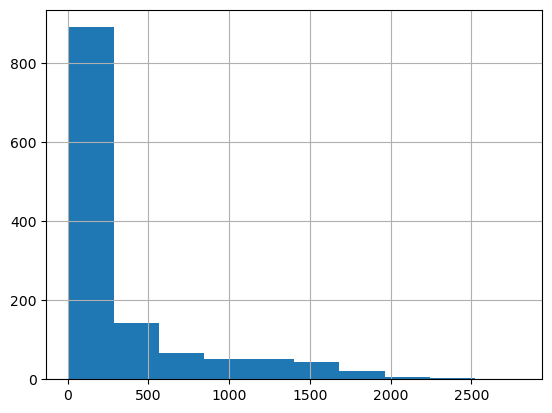

In [7]:
data_key_retail = data_key['retail']
data_key_retail.hist()

In [15]:
retail_arr = data_key_retail.sort_values(ignore_index=True)

In [13]:
retail_arr.quantile(q=0.8)

499.99